In [59]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
import spikeinterface.widgets as sw
import spikeinterface as si
from pathlib import Path
import time
import matplotlib.pyplot as plt
from Timer import Timer
from spikegadget2nwb.preproc_func import get_bad_ch_id, rm_artifacts, parse_session_info
import numpy as np
import os
import mountainsort5 as ms5
import spikeinterface.exporters as sexp


rec_folder = r"D:\cl\rf_reconstruction\freelymoving\CnL22_20241218_130546.rec"
animal_id, session_id = parse_session_info(rec_folder)

ishs = ['0', '1', '2', '3']


rec_folder = Path(rec_folder)

In [60]:
ish = '0'
nwb_folder = Path(rec_folder) / f'{animal_id}_{session_id}.recsh{ish}.nwb'
out_folder = Path('sortout') / animal_id / session_id / ish
if not out_folder.exists():
    out_folder.mkdir(parents=True)


recording = se.NwbRecordingExtractor(nwb_folder)
print(recording)

NwbRecordingExtractor: 32 channels - 30.0kHz - 1 segments - 74,666,980 samples 
                       2,488.90s (41.48 minutes) - int16 dtype - 4.45 GiB
  file_path: D:\cl\rf_reconstruction\freelymoving\CnL22_20241218_130546.rec\CnL22_20241218_130546.recsh0.nwb


conventional 2nd derivative method

In [61]:
# 2. Get info about channels
channel_ids = recording.get_channel_ids()
channel_locations = recording.get_channel_locations()  # shape: (num_channels, 2) or (num_channels, 3)

print("Channel IDs:", channel_ids)
print("Channel locations:\n", channel_locations)

Channel IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Channel locations:
 [[  0. 250.]
 [  0.  50.]
 [  0.   0.]
 [  0.  25.]
 [ 25. 225.]
 [ 25. 200.]
 [  0. 200.]
 [ 25. 175.]
 [  0. 225.]
 [  0. 175.]
 [ 25. 375.]
 [ 25. 150.]
 [  0. 375.]
 [  0. 150.]
 [ 25. 350.]
 [ 25. 125.]
 [ 25. 100.]
 [  0. 350.]
 [ 25.  75.]
 [ 25. 325.]
 [ 25.  50.]
 [  0. 325.]
 [ 25.  25.]
 [ 25. 300.]
 [ 25.   0.]
 [  0. 300.]
 [  0. 125.]
 [ 25. 275.]
 [  0. 100.]
 [  0. 275.]
 [  0.  75.]
 [ 25. 250.]]


In [62]:
# 3. Identify which coordinate is depth
depth_axis = 1  # or 2, depending on your probe's coordinate system
depths = channel_locations[:, depth_axis]

# 4. Sort by ascending depth
sorted_idx = np.argsort(depths)

# 5. Reorder channels according to sorted_idx
sorted_channel_ids = [channel_ids[i] for i in sorted_idx]

print("Sorted channel IDs by depth:", sorted_channel_ids)
print("Corresponding sorted depths:", depths[sorted_idx])


Sorted channel IDs by depth: [2, 24, 3, 22, 20, 1, 30, 18, 16, 28, 26, 15, 13, 11, 7, 9, 6, 5, 8, 4, 0, 31, 27, 29, 23, 25, 21, 19, 17, 14, 12, 10]
Corresponding sorted depths: [  0.   0.  25.  25.  50.  50.  75.  75. 100. 100. 125. 125. 150. 150.
 175. 175. 200. 200. 225. 225. 250. 250. 275. 275. 300. 300. 325. 325.
 350. 350. 375. 375.]


In [63]:
# 6. Make a new recording object with channels sorted by depth
recording_sorted = recording.channel_slice(sorted_channel_ids)

In [64]:
from spikeinterface.preprocessing import bandpass_filter, common_reference

# e.g., bandpass filter to get 1-300 Hz, typical LFP range
recording_lfp = bandpass_filter(recording_sorted, freq_min=1, freq_max=300)
# Optionally downsample from 30 kHz -> 1 or 2 kHz (makes handling 41-min data easier)
# recording_lfp = recording_filt.downsample(sampling_frequency=1000)
recording_ref = common_reference(recording_lfp, reference='global', operator='median')


In [65]:
# Example: separate columns by unique x-coordinates
channel_locs_sorted = recording_sorted.get_channel_locations()
x_coords = channel_locs_sorted[:, 0]  # if x is at index 0
unique_x = np.unique(x_coords)

# Column 1
col1_indices = np.where(x_coords == unique_x[0])[0]

# Column 2
col2_indices = np.where(x_coords == unique_x[1])[0]

# (Optional) If you want to average columns at each depth:
# Make sure col1_indices[i] and col2_indices[i] correspond to the same depth
# This can be done by verifying sorted depths and pairing them

In [66]:
lfp = recording_lfp.get_traces()
downsample_rate = 10
lfp = lfp[::downsample_rate, :]

In [67]:
lfp1 = lfp[:, col1_indices]
lfp2 = lfp[:, col2_indices]
lfp_avg = (lfp1 + lfp2) / 2
lfp_avg = lfp_avg.T

In [68]:
# Inter-electrode spacing (25 µm). Convert to meters for SI units if desired:
dz = 25e-6  # in meters

# Second-difference: CSD ~ (V[i+1] - 2V[i] + V[i-1]) / dz^2
# We'll compute for channels 1..(n-2) to avoid boundary issues
V = lfp_avg
second_diff = V[2:, :] - 2 * V[1:-1, :] + V[:-2, :]
csd_standard = -second_diff / (dz**2)  # negative sign from physics convention
# shape: (num_channels-2, num_timepoints)


In [69]:
from neo.core import AnalogSignal
import quantities as pq
from elephant.current_source_density import estimate_csd

lfp_data_T = lfp_avg.T  # shape: (num_timepoints, num_channels)
analog_lfp = AnalogSignal(lfp_data_T, units=pq.V,
                          sampling_rate=(recording_lfp.get_sampling_frequency() / downsample_rate) * pq.Hz)
# Annotate electrode depths
depth_values = np.linspace(0, (lfp_avg.shape[0] - 1) * dz, lfp_avg.shape[0])
depth_coords = [(d * dz,) for d in depth_values] * pq.m

In [70]:
# analog_lfp.annotate(coordinates=depth_coords)

# # Kernel-based CSD
# csd_analog = estimate_csd(analog_lfp, method='KCSD1D')  # returns another AnalogSignal
# csd_kernel = csd_analog.magnitude.T  # shape: (num_channels or interpolated, num_timepoints)

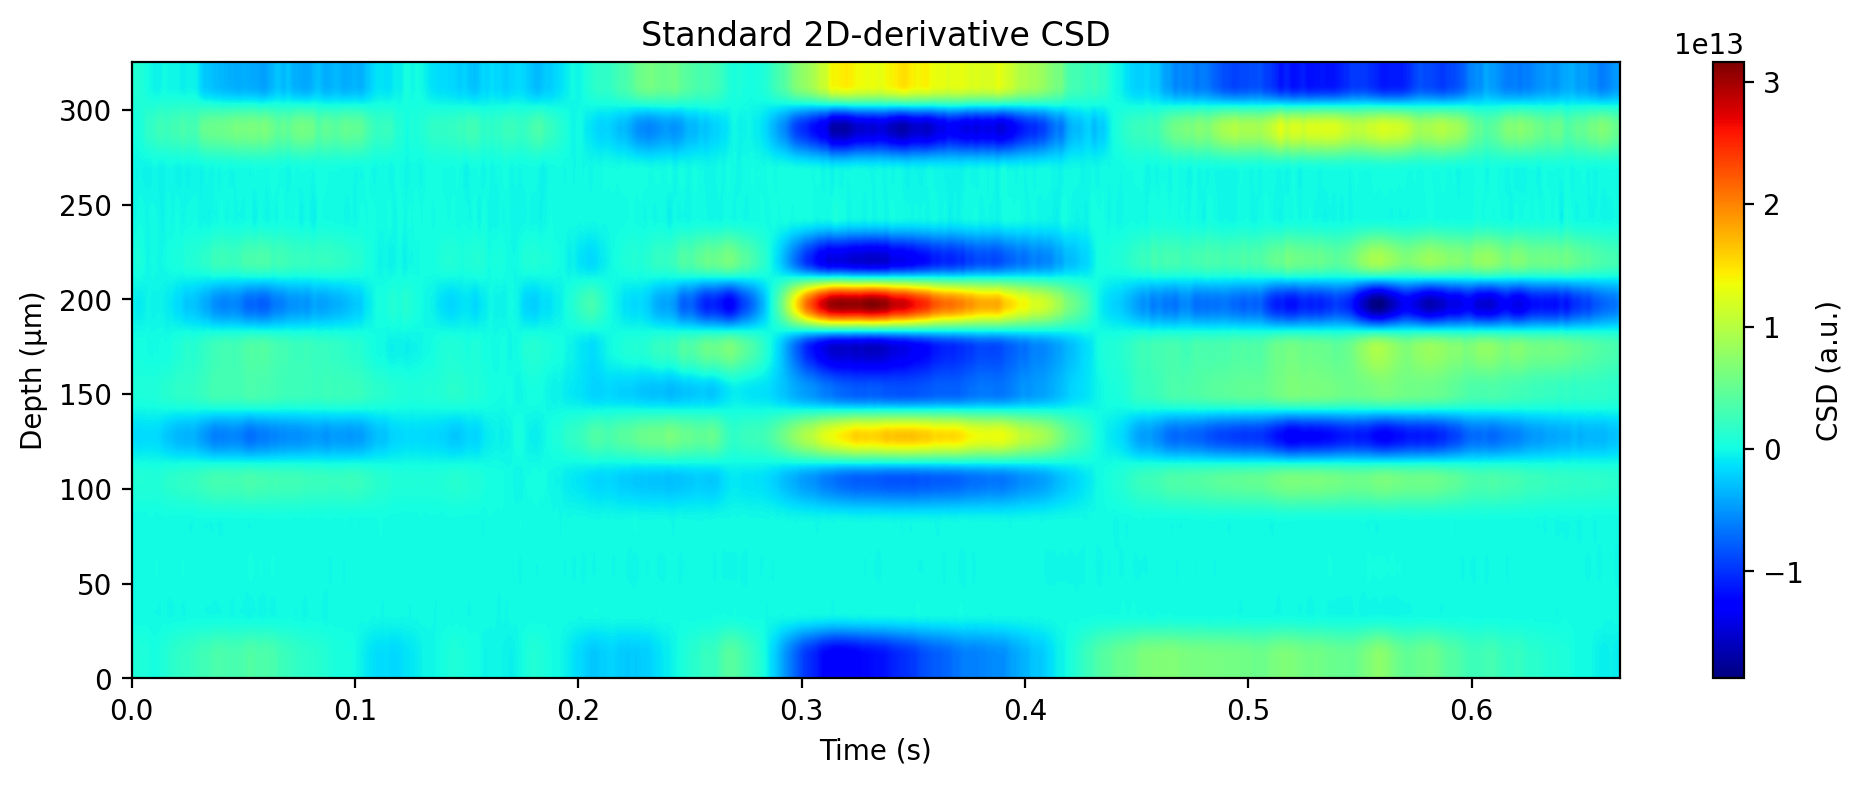

In [71]:
import matplotlib.pyplot as plt

# Suppose we have csd_standard of shape (n_depths, n_timepoints)
n_timepoints = csd_standard.shape[1]
fs = recording_lfp.get_sampling_frequency() / downsample_rate

depth_axis = np.arange(csd_standard.shape[0]) * 25.0  # in µm if each channel is 25 µm deeper

plt.figure(figsize=(12,4), dpi=200)
csd_plot = csd_standard[:, 30000:32000]
time_axis = np.arange(csd_plot.shape[1]) / fs
plt.imshow(csd_plot, aspect='auto', cmap='jet', origin='lower',
           extent=[time_axis[0], time_axis[-1], depth_axis[0], depth_axis[-1]])

plt.colorbar(label='CSD (a.u.)')
plt.title('Standard 2D-derivative CSD')
plt.xlabel('Time (s)')
plt.ylabel('Depth (μm)')
plt.show()


In [72]:
import matplotlib.pyplot as plt

# Select a time window for visualization (e.g., first 1 second or a particular event interval)
Fs = recording_ref.get_sampling_frequency()
t_start = 0
t_end = int(Fs * 1.0)   # 1 second of data
csd_std_segment = csd_standard[:, t_start:t_end]
csd_kern_segment = csd_kernel[:csd_standard.shape[0], t_start:t_end]  # match depths (if kernel has more depths, trim or interpolate)

# Plot standard CSD heatmap
plt.figure(figsize=(6,4))
plt.imshow(csd_std_segment, aspect='auto', cmap='seismic', origin='lower',
           extent=[0, 1.0, 0, lfp_depth_avg.shape[0]*25])  # extent in seconds and micrometers
plt.colorbar(label='CSD (a.u.)')
plt.title('Standard CSD (Second Derivative)')
plt.xlabel('Time (s)')
plt.ylabel('Depth (μm)')

# Plot kernel-based CSD heatmap
plt.figure(figsize=(6,4))
plt.imshow(csd_kern_segment, aspect='auto', cmap='seismic', origin='lower',
           extent=[0, 1.0, 0, lfp_depth_avg.shape[0]*25])
plt.colorbar(label='CSD (a.u.)')
plt.title('Kernel CSD (KCSD1D)')
plt.xlabel('Time (s)')
plt.ylabel('Depth (μm)')


NameError: name 'csd_kernel' is not defined